# Data
- Select dataset and output some metadata

In [1]:
from domain.env import SWS, FEATURE_ENCODING, DATA_SLICE_AMOUNT, X_type, Y

print(f"use '{SWS}' dataset with {FEATURE_ENCODING} encoding, {DATA_SLICE_AMOUNT} samples and performance metric: {Y}")

use 'LLVM_energy' dataset with binary encoding, 10000 samples and performance metric: energy


In [2]:
from application.init_pipeline import init_pipeline
from application.fully_bayesian_gp import get_data

ds, feature_names, X_train, X_test, y_train, y_test = init_pipeline(use_dummy_data=False, extra_features="polynomial" if False else None, scaler="minmax")
data = get_data()
X_train, X_test, y_train, y_test, feature_names = data
measurement_df = ds.get_measurement_df()

Checking if LLVM_energy isn't already extracted
   root  ee_instrument  simplifycfg  ipsccp  called_value_propagation  \
0     1              0            0       0                         0   
1     1              0            0       0                         0   
2     1              0            0       0                         0   
3     1              0            0       0                         0   
4     1              0            0       0                         0   

   basicaa  instcombine  inline  mergereturn  jump_threading  ...  licm  sink  \
0        0            0       0            0               0  ...     0     0   
1        0            0       0            0               0  ...     0     0   
2        0            0       0            0               0  ...     0     0   
3        0            0       0            0               0  ...     0     0   
4        0            0       0            0               0  ...     0     1   

   gvn  sccp  adce  perfor

/home/immanuel/.conda/envs/bayesrisk/lib/python3.9/site-packages/numpy/lib/function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/immanuel/.conda/envs/bayesrisk/lib/python3.9/site-packages/numpy/lib/function_base.py:2830: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


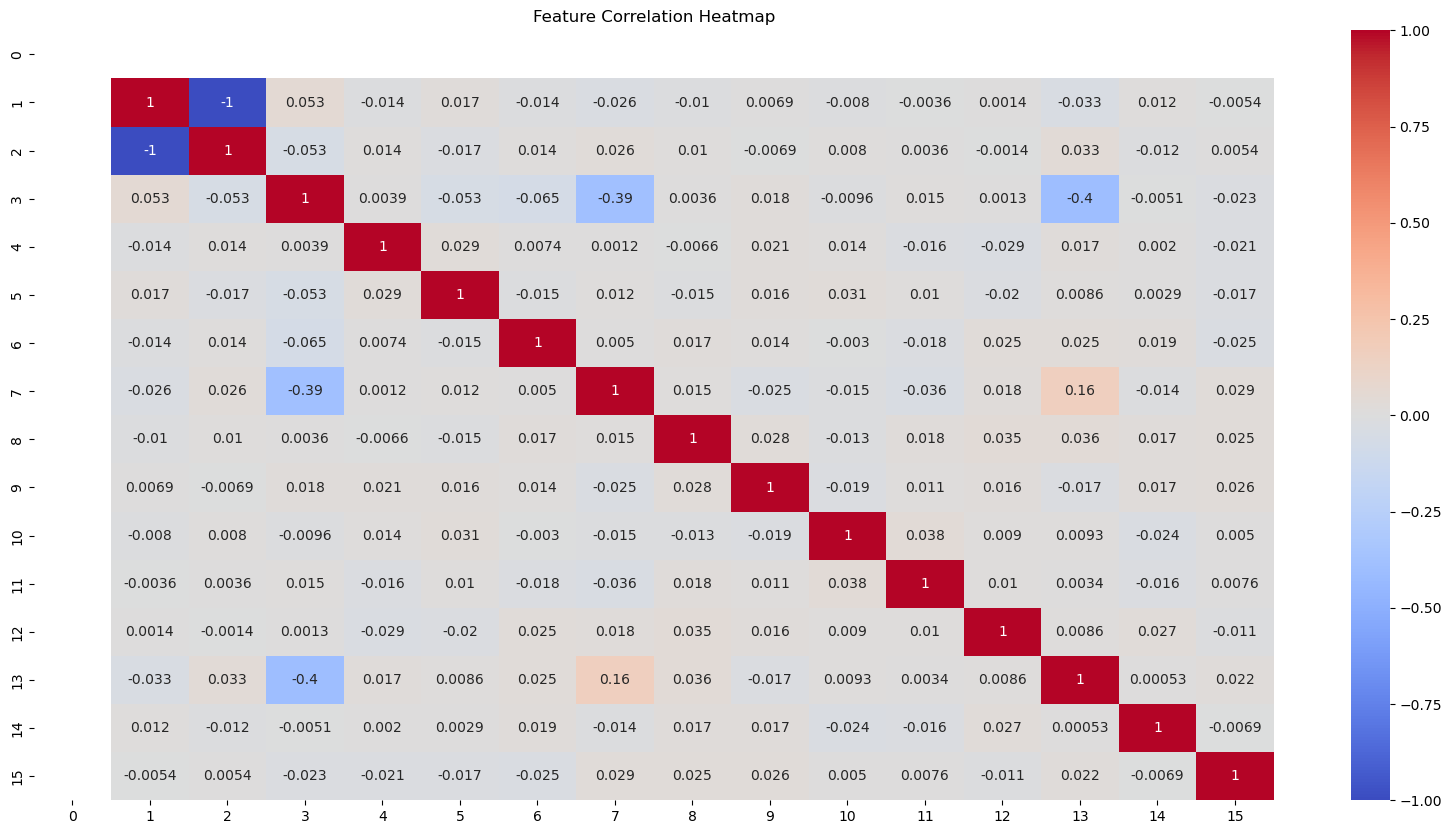

In [3]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pointbiserialr

#corr_matrix = measurement_df.corr(method=pointbiserialr)
corr_matrix = np.corrcoef(X_train.T)
#corr_matrix = measurement_df.corr()

# Heatmap
plt.figure(figsize=(20,10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

# Pair Plot
#sns.pairplot(measurement_df, hue="sink")
#plt.show()

In [4]:
mean_corr = measurement_df.corr().drop(columns=["y"], index=["y"]).abs().mean().mean()
mean_corr
target_corr = measurement_df.corr()["y"].abs()
selected_features = target_corr[target_corr > mean_corr].index.tolist()
selected_features.remove("y")
print("Selected Features:", selected_features)

Selected Features: ['adce', 'called_value_propagation', 'inline', 'instcombine', 'ipsccp', 'jump_threading', 'licm', 'pgo_memop_opt', 'sink', 'tailcallelim']


basicaa                     443.160346
ipsccp                      209.160545
pgo_memop_opt               201.924331
inline                      175.106187
tailcallelim                 92.455385
sink                         67.448197
jump_threading               60.349463
licm                         59.937437
instcombine                  55.711919
gvn                          40.082271
mergereturn                  23.507474
ee_instrument                13.179974
simplifycfg                   9.877794
sccp                          2.040888
adce                          0.000000
called_value_propagation      0.000000
dtype: float64


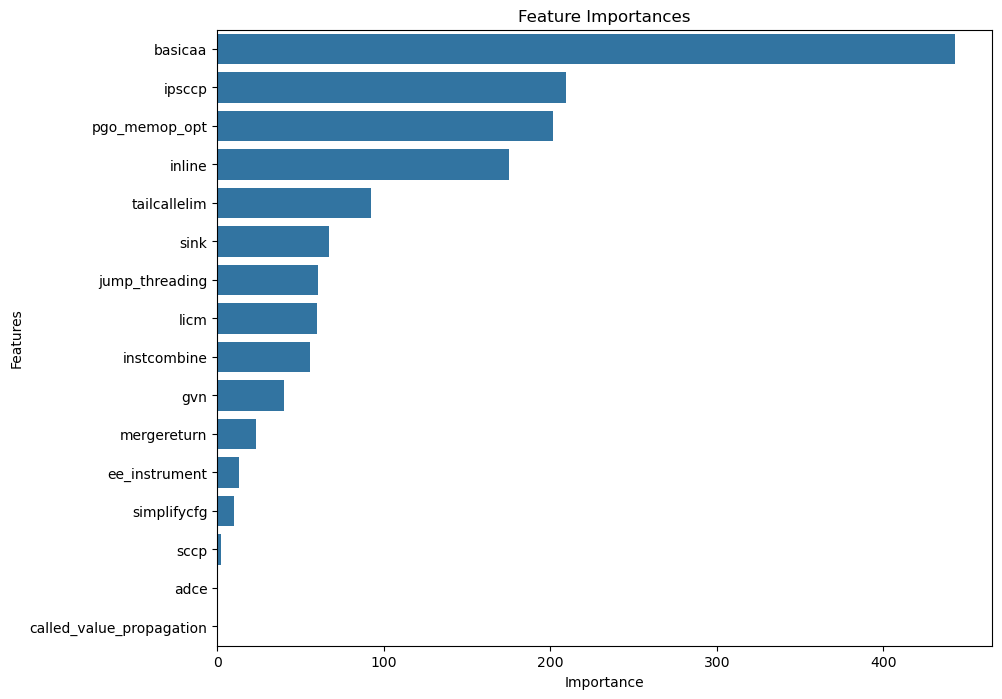

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.linear_model import LinearRegression, LassoCV

# Fit the model
model = LassoCV(alphas=np.logspace(-2, 4, 1000))
model.fit(X_train, y_train)  # X is your features, y is your target variable

# Feature importances are the absolute values of the coefficients
feature_importances = pd.Series(abs(model.coef_), index=feature_names)

# Assuming 'feature_importances' is a dictionary or a Pandas Series 
# with feature names as keys and their importance (e.g., correlation coefficient) as values
# Example: feature_importances = {'feature1': 0.8, 'feature2': 0.75, ...}

# Convert to Pandas Series for easy plotting if it's not already
#feature_importances = measurement_df.corr()["y"].abs().sort_values(ascending=False)
feature_importances = pd.Series(feature_importances)

# Sort features based on importance
sorted_features = feature_importances.sort_values(ascending=False)
print(sorted_features)

# Create a bar plot
plt.figure(figsize=(10, 8))
sns.barplot(x=sorted_features.values, y=sorted_features.index)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()


## model metrics
- MSE
- MAPE
- WAIC

In [8]:
import matplotlib.pyplot as plt
import networkx as nx
import math
import numpy as np
import random

def add_nodes(tree, current_node, max_depth, feature_names, current_depth=1):
    if current_depth > max_depth or len(feature_names) == 0:
        return

    # Randomly select features for left and right child nodes
    left_feature = feature_names.pop(random.randint(0, len(feature_names) - 1)) if feature_names else None
    right_feature = feature_names.pop(random.randint(0, len(feature_names) - 1)) if feature_names else None

    left_child = current_node * 2
    right_child = current_node * 2 + 1

    if left_feature:
        tree.add_node(left_child, label=left_feature, size=feature_importances.get(left_feature, 1))
        tree.add_edge(current_node, left_child)
    if right_feature:
        tree.add_node(right_child, label=right_feature, size=feature_importances.get(right_feature, 1))
        tree.add_edge(current_node, right_child)

    add_nodes(tree, left_child, max_depth, feature_names, current_depth + 1)
    add_nodes(tree, right_child, max_depth, feature_names, current_depth + 1)


def get_tree_layout(tree, root, width=4.0, vert_gap = 0.8, vert_loc = 0, xcenter = 0.5):
    """
    Creates a layout for nodes in a binary tree.
    """
    if not nx.is_tree(tree):
        raise TypeError('cannot use hierarchy_pos on a graph that is not a tree')

    def _hierarchy_pos(G, root, width=4.0, vert_gap = 0.8, vert_loc = 0, xcenter = 0.5, pos = None, parent = None):
        if pos is None:
            pos = {root:(xcenter,vert_loc)}
        else:
            pos[root] = (xcenter, vert_loc)
        children = list(G.neighbors(root))
        if not isinstance(G, nx.DiGraph) and parent is not None:
            children.remove(parent)  
        if len(children) != 0:
            dx = width / 2 
            nextx = xcenter - width/2 - dx/2
            for child in children:
                nextx += dx
                pos = _hierarchy_pos(G, child, width = dx, vert_gap = vert_gap, 
                                    vert_loc = vert_loc-vert_gap, xcenter=nextx, pos=pos, 
                                    parent = root)
        return pos

    return _hierarchy_pos(tree, root, width, vert_gap, vert_loc, xcenter)

# Example feature names and synthetic importance values
#feature_names = measurement_df.columns.tolist()
feature_names = list(feature_names)
feature_importances = {feature: np.random.uniform(0.5, 1.5) for feature in feature_names}  # Replace with actual importances

# Shuffle feature names to randomly assign them to tree nodes
random.shuffle(list(feature_names))

# Create a balanced binary tree
tree = nx.DiGraph()
root_feature = feature_names.pop(0)
tree.add_node(1, label=root_feature, size=feature_importances.get(root_feature, 1))

# Calculate the depth of the tree
depth = math.ceil(math.log2(len(measurement_df.columns) + 1))
add_nodes(tree, 1, depth, feature_names)

# Get tree layout
pos = get_tree_layout(tree, 1)
sizes = [tree.nodes[node]['size']*500 for node in tree.nodes()]
colors = ['skyblue' if node in feature_list else 'lightgray' for node in tree.nodes()]

# Draw the tree
plt.figure(figsize=(20, 15))
nx.draw(tree, pos, with_labels=True, labels=nx.get_node_attributes(tree, 'label'), node_color=colors, node_size=sizes, font_size=12, arrows=False)
plt.title('Balanced Binary Dependency Graph of Features')
plt.show()


NameError: name 'feature_list' is not defined

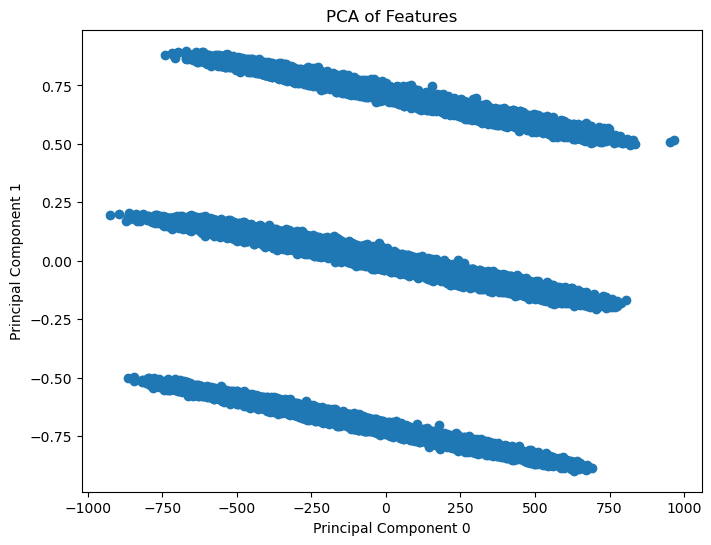

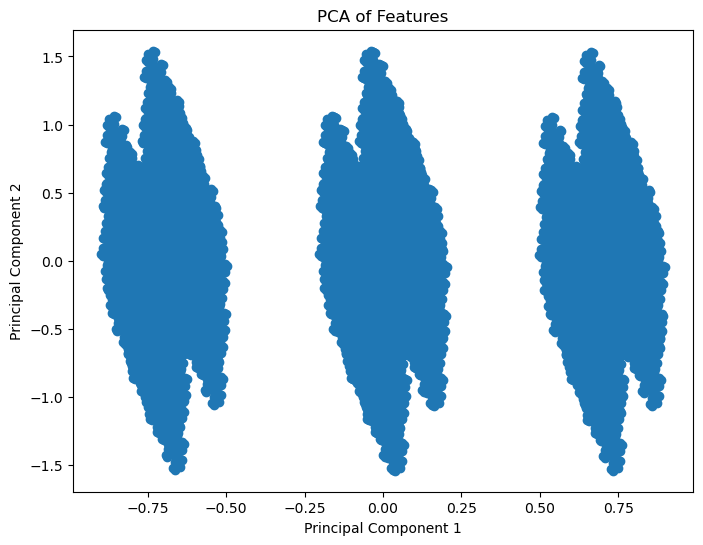

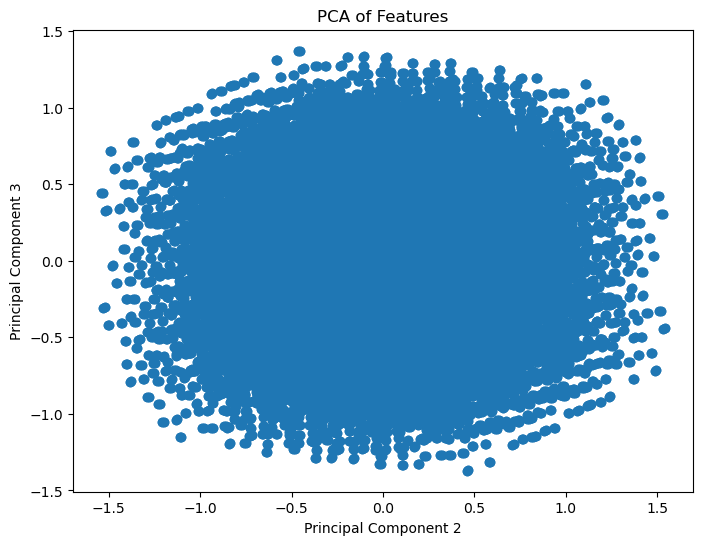

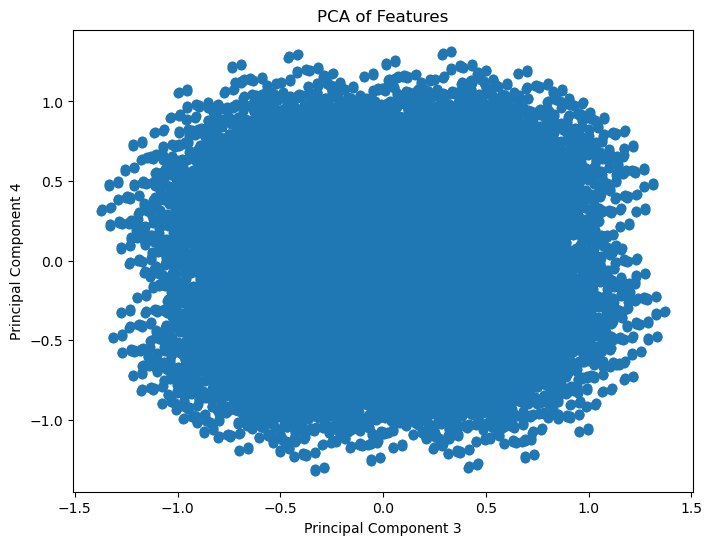

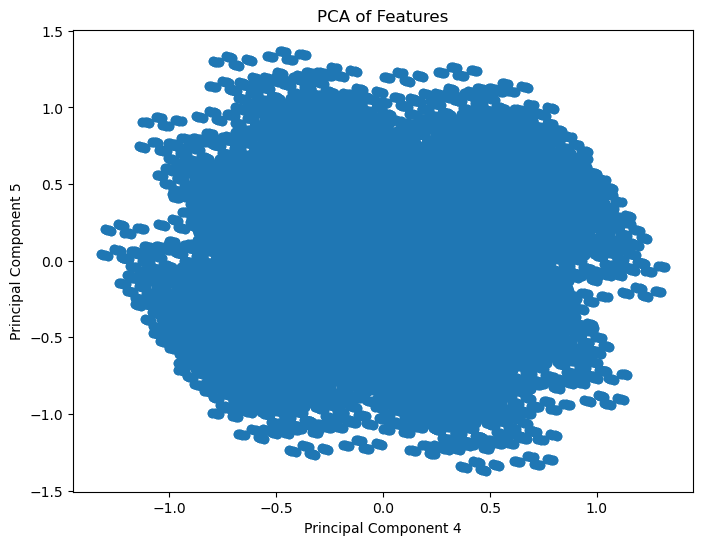

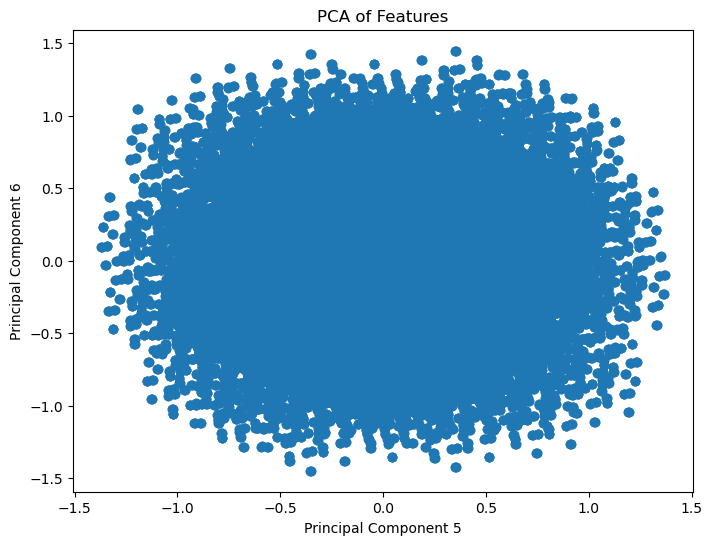

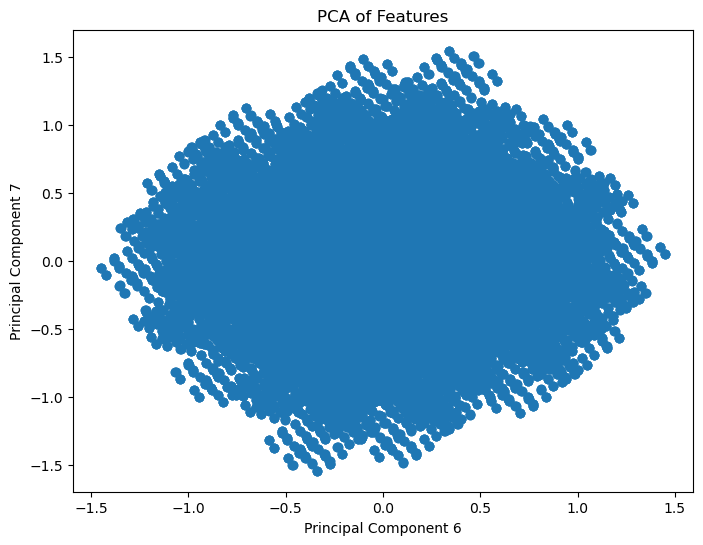

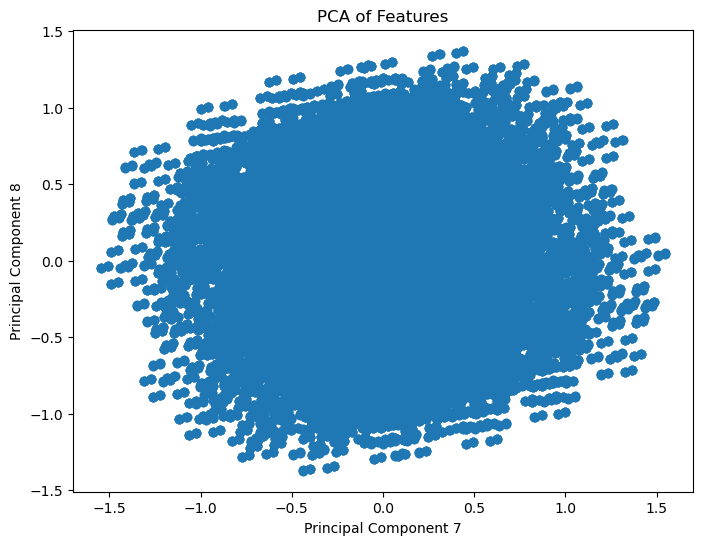

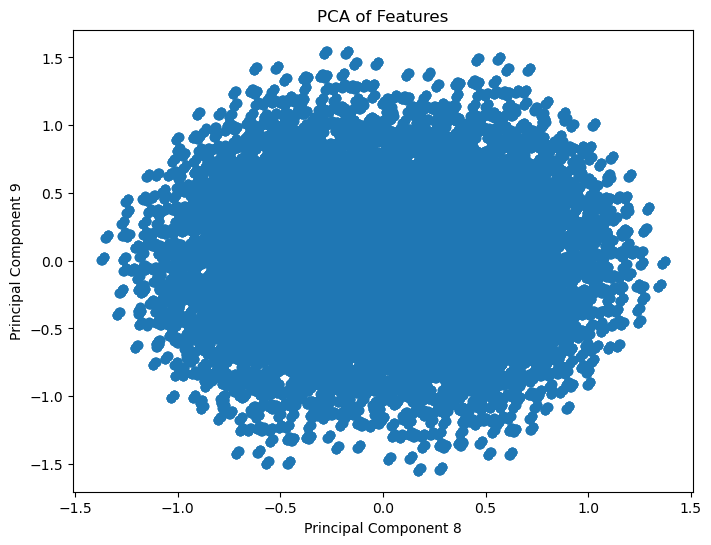

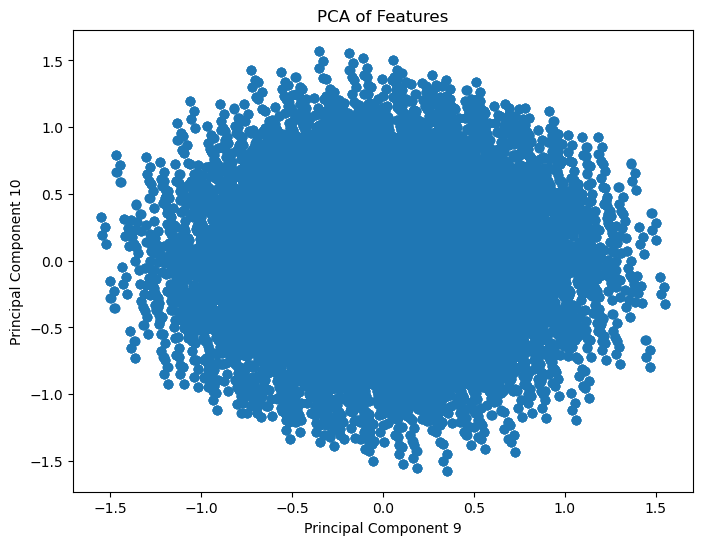

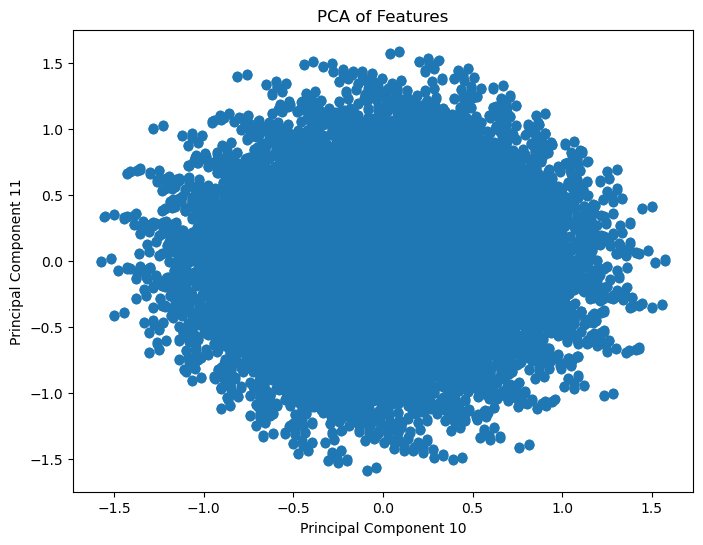

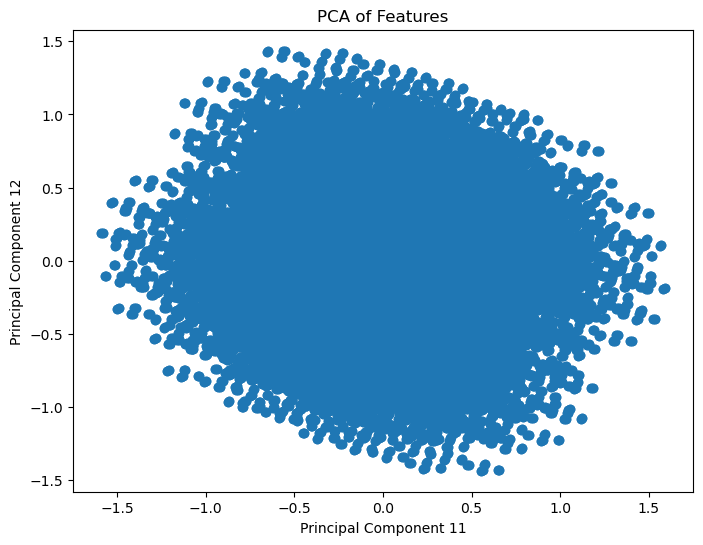

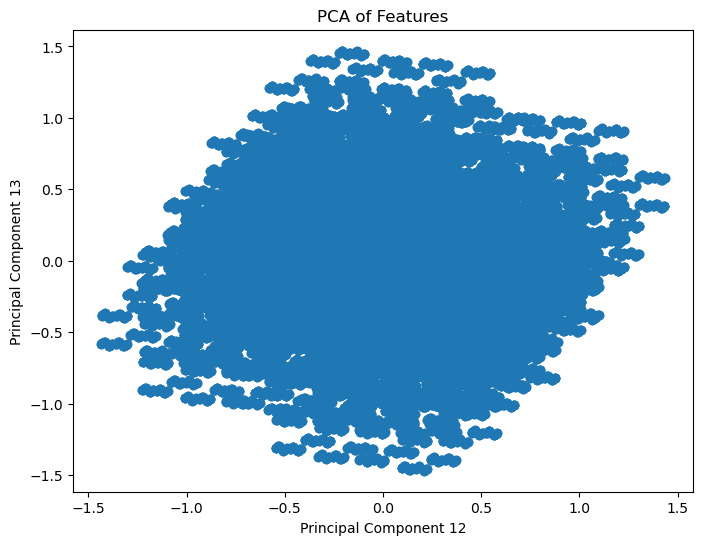

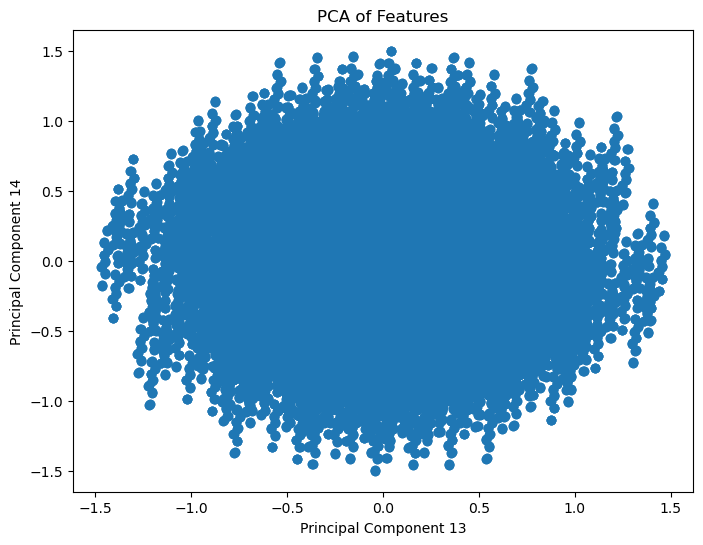

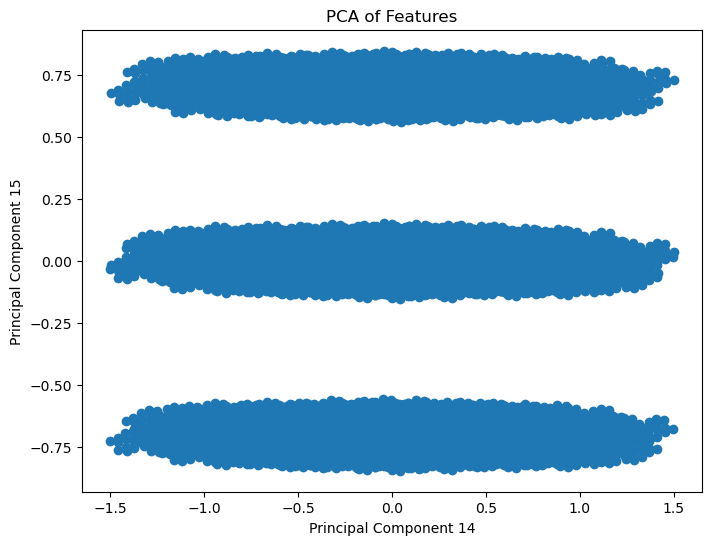

In [9]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Perform PCA
pca = PCA(n_components=len(X_train.T))
#reduced_features = pca.fit_transform(X=X_train,y=y_train)
reduced_features = pca.fit_transform(measurement_df)

# Scatter plot of the first two principal components
for component in range(len(reduced_features.T)-1):
        plt.figure(figsize=(8, 6))
        plt.scatter(reduced_features[:, component], reduced_features[:, component+1])
        plt.xlabel(f'Principal Component {component}')
        plt.ylabel(f'Principal Component {component+1}')
        plt.title('PCA of Features')
        plt.show()


=> We can see clearly, that some interactions are linear separable, while most of them are not, beside having distinctive shapes indicating some interaction pattern

## pairwise interactions in KernelPCA

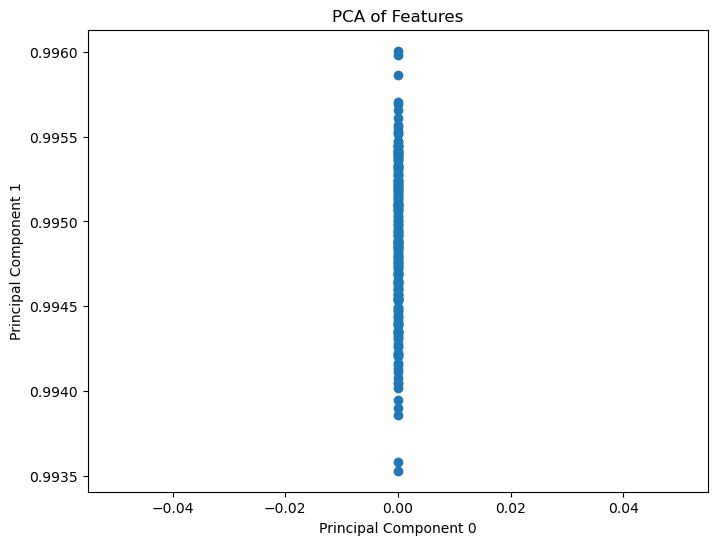

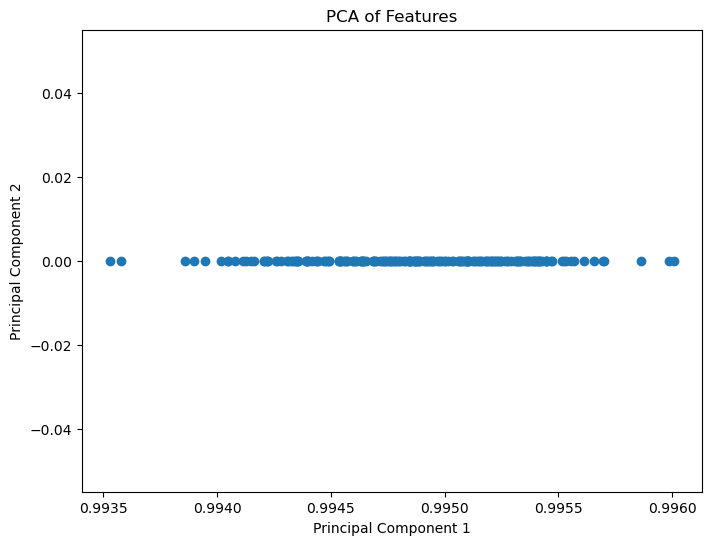

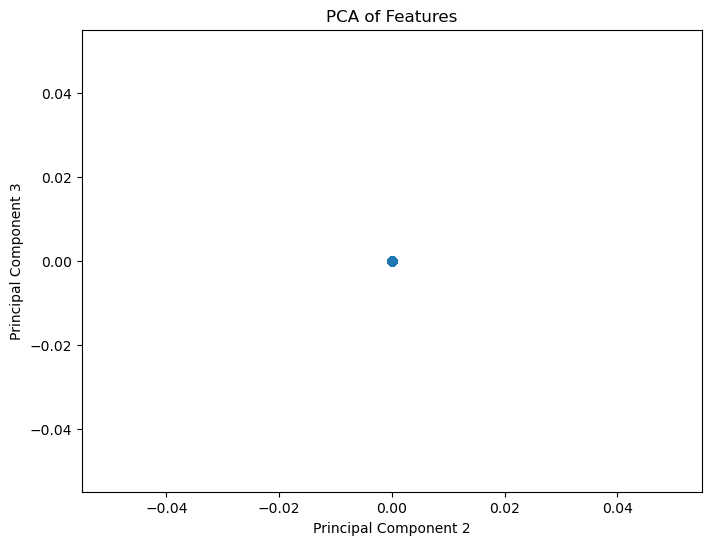

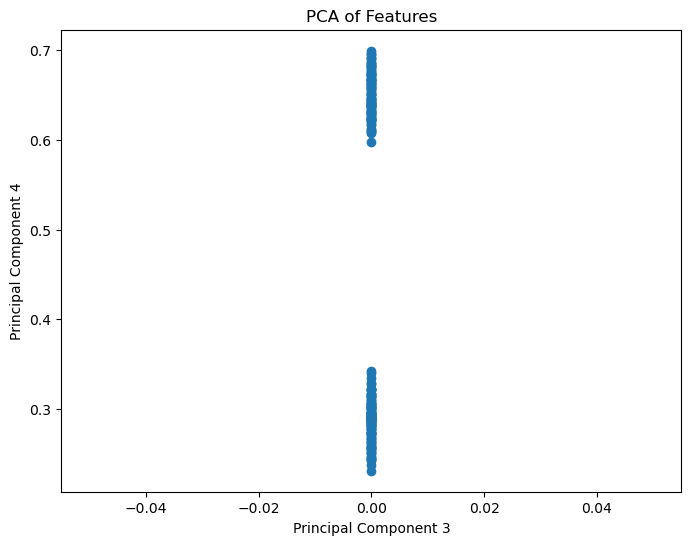

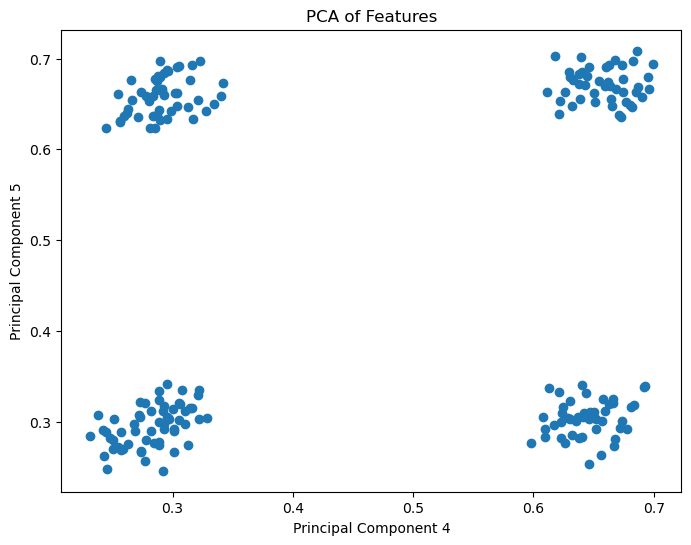

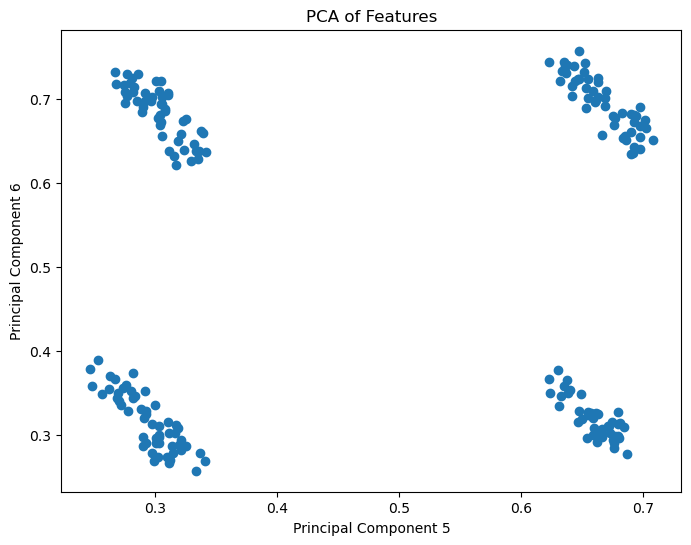

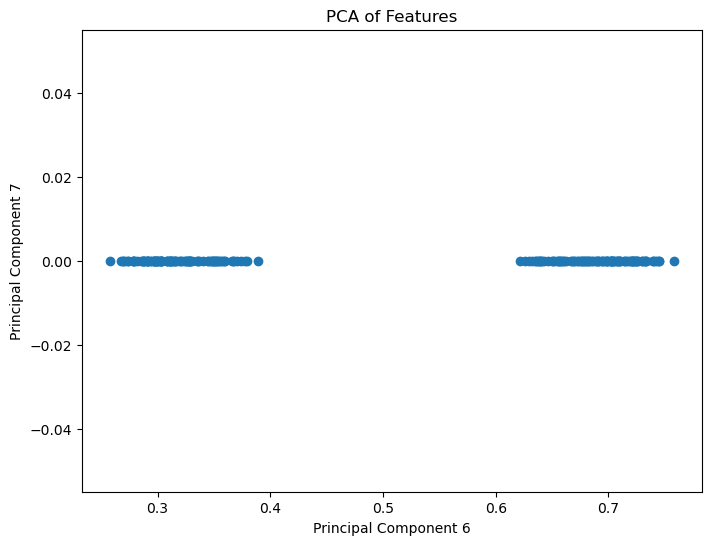

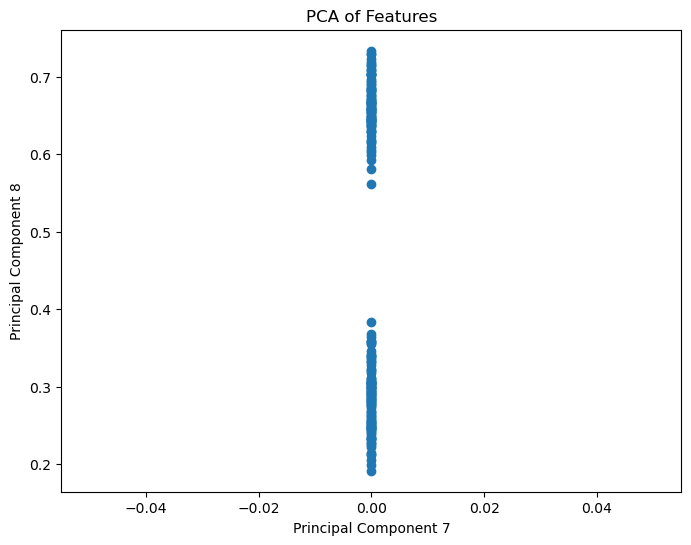

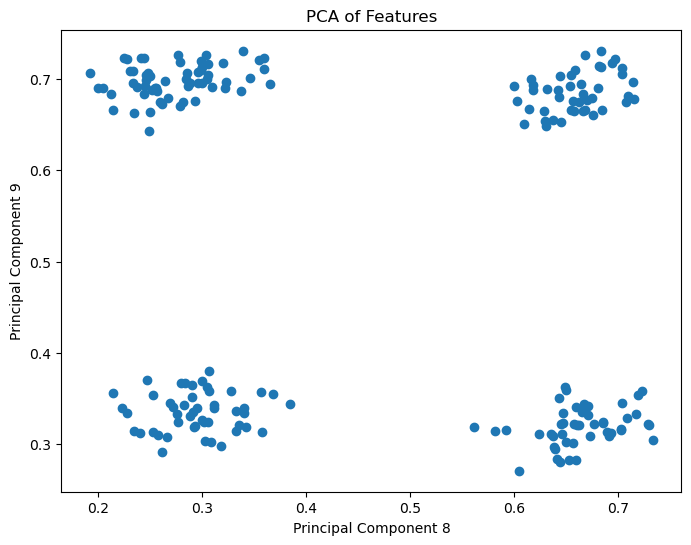

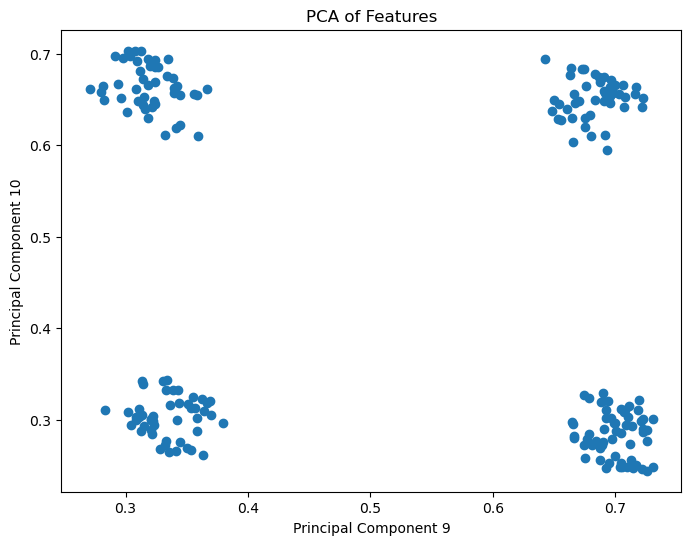

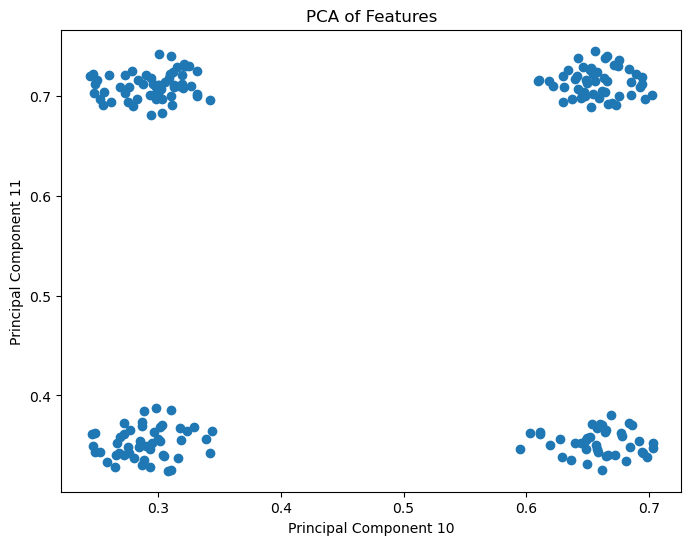

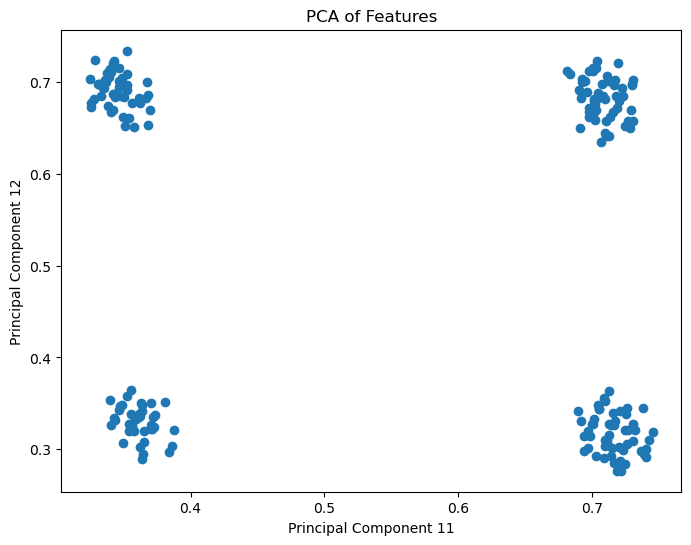

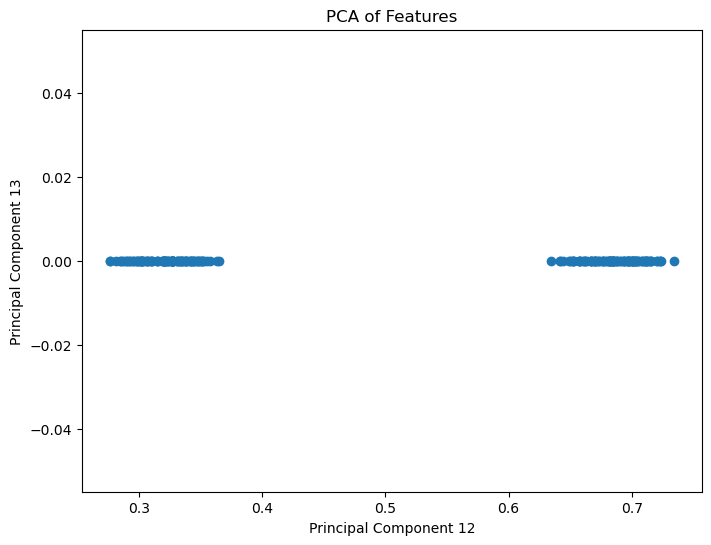

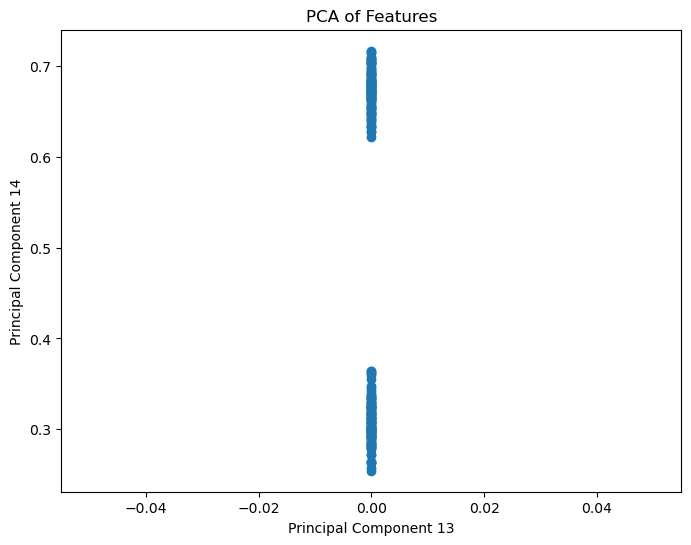

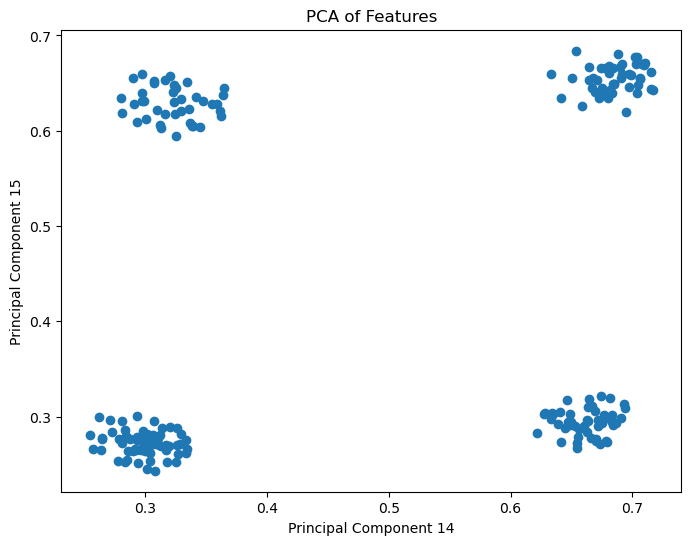

In [10]:
from sklearn.decomposition import KernelPCA
import matplotlib.pyplot as plt

# Perform PCA
#pca = PCA(n_components=len(X_train.T))
pca = KernelPCA(kernel="rbf", n_components=len(X_train.T), fit_inverse_transform=True)
kpca = pca.fit_transform(X=X_train,y=y_train)
reduced_features = pca.inverse_transform(kpca)

# Scatter plot of the first two principal components
for component in range(len(reduced_features.T)-1):
        plt.figure(figsize=(8, 6))
        plt.scatter(reduced_features[:, component], reduced_features[:, component+1])
        plt.xlabel(f'Principal Component {component}')
        plt.ylabel(f'Principal Component {component+1}')
        plt.title('PCA of Features')
        plt.show()


- using a proper kernel, the data gets linear separated and variance reduced

##### This indicates, that a Gaussian Process Regression for multivariate normal distribution among the features is suitable

# Feature Engineering
## hierarchical constrains and views
- AVL tree inducing a ordered feature dict
## non-linear / latent feature selection
- we might want to constrain the training data to have specific feature combinations available
  - using boolean logic (CNFs/DNFs) to select feature combinations
- inspect data to detect a priori interaction patterns
    - we might want to intensify inspections on features that have a high correlation coefficient

## Polynomial Interaction Sampler
- using boolean algebra according to https://en.wikipedia.org/wiki/Zhegalkin_polynomial

### Decomposing feature strings
- imagine we have a binary encoded feature string / vector *p = 1011011* and want to know which features may interact with another
  vector *q = 1101101*, then we can just subtract q from p and look which feature combinations I have to add, to produce q:
  
  **p - q = 1000000 + 1000 + 1 - (10010 + 1110 + 10)**

- So when interested in interactions between p and q, we have to consider interactions between each substring and its opposite

### Boolean Feature Masks
- for **interactions** we concat samples with specific feature combinations **A** with a logical **AND**
- to get the **opposites not(A)**, we concat with **NAND**

In [21]:
def build_masks(X, conditions):
    masks = []
    for pos, opt in conditions:
        if len(X.T) < pos < 0:
            raise ValueError("pos must be a valid index of X.")
        if type(opt) != bool and opt not in [0,1]:
            raise ValueError("opt must be a \"boolean\".")
        masks.append(X[:,pos] == opt)
    return masks

def get_words(X, masks, clause="or"):
    if clause == "or":
        return X[np.logical_or(*masks)]
    elif clause == "nor":
        return X[np.logical_not(np.logical_or(*masks))]
    elif clause == "and":
        return X[np.logical_and(*masks)]
    elif clause == "nand":
        return X[np.logical_not(np.logical_and(*masks))]
    elif clause == "xor":
        return X[np.logical_xor(*masks)]


def get_interactions(X, features):
    masks = build_masks(X, features)
    print(masks)
    interactions = get_words(X, masks, clause="and")
    return interactions

def get_opposites(X, features):
    masks = build_masks(X, features)
    print(masks)
    opposites = get_words(X, masks, clause="nand")
    return opposites

feature_interactions = [(1,0),(2,1),(3,1)]
A = get_interactions(np.array(X_train), feature_interactions)
not_A = get_opposites(np.array(X_test), feature_interactions)

print(f"A: {A}\n")
print(f"not A: {not_A}")


print("sanity check, if A and not_A are distinct")
if np.size(np.setdiff1d(A,not_A)) == 0:
    print(True)
else:
    print(False)

[array([False,  True,  True, ..., False, False,  True]), array([False,  True,  True, ..., False, False,  True]), array([False, False, False, ..., False, False, False])]
[array([ True, False,  True, ...,  True, False,  True]), array([ True, False,  True, ...,  True, False,  True]), array([False, False, False, ..., False, False, False])]
A: [[0. 0. 1. ... 1. 1. 0.]
 [0. 0. 1. ... 1. 1. 0.]
 [0. 0. 1. ... 0. 1. 1.]
 ...
 [0. 0. 1. ... 0. 0. 1.]
 [0. 0. 1. ... 1. 1. 1.]
 [0. 0. 1. ... 1. 1. 1.]]

not A: [[0. 1. 0. ... 1. 0. 0.]
 [0. 1. 0. ... 1. 1. 0.]
 [0. 1. 0. ... 1. 0. 1.]
 ...
 [0. 1. 0. ... 1. 1. 0.]
 [0. 1. 0. ... 1. 0. 0.]
 [0. 1. 0. ... 0. 0. 1.]]
sanity check, if A and not_A are distinct
True
